In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pptk

plt.rcParams["figure.dpi"] = 200
from scipy.signal import savgol_filter, convolve

import skeletor as sk

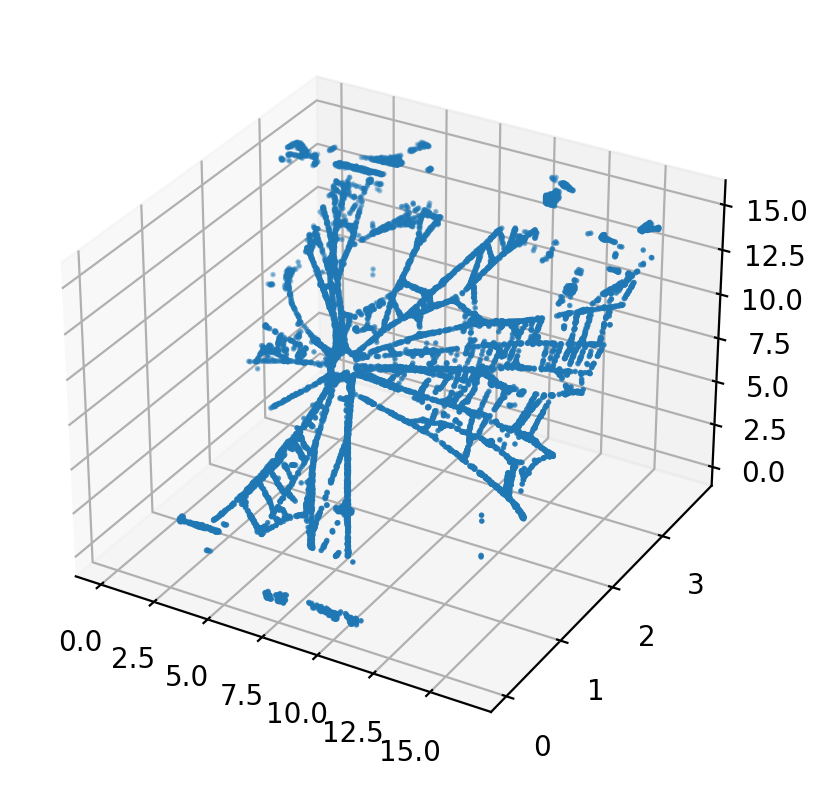

In [2]:
data = 'Data/2d_web_scan.npy'
dsFactor = 5
neighborDistance = .5
np.random.seed(10)

#%matplotlib qt
with open(data, 'rb') as f:
    rawData = np.load(f)
    
order = np.arange(rawData.shape[0])
np.random.shuffle(order)
points = rawData[order][::dsFactor,:]

# Subtract off minima
points = points - np.min(points, axis=0)

# Scale (note that these are approximate, and shouldn't be
# used for any calculations or anything).
scalingFactors = np.array([14/2000, 4/2000, 80/2000])

points = points*scalingFactors

#plt.scatter(scatterPoints[:,0], scatterPoints[:,2], s=.2)
#plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(*points.T, s=1)
plt.show()

In [8]:
adjMat = sk.calculateAdjacencyMatrix(points, neighborDistance)

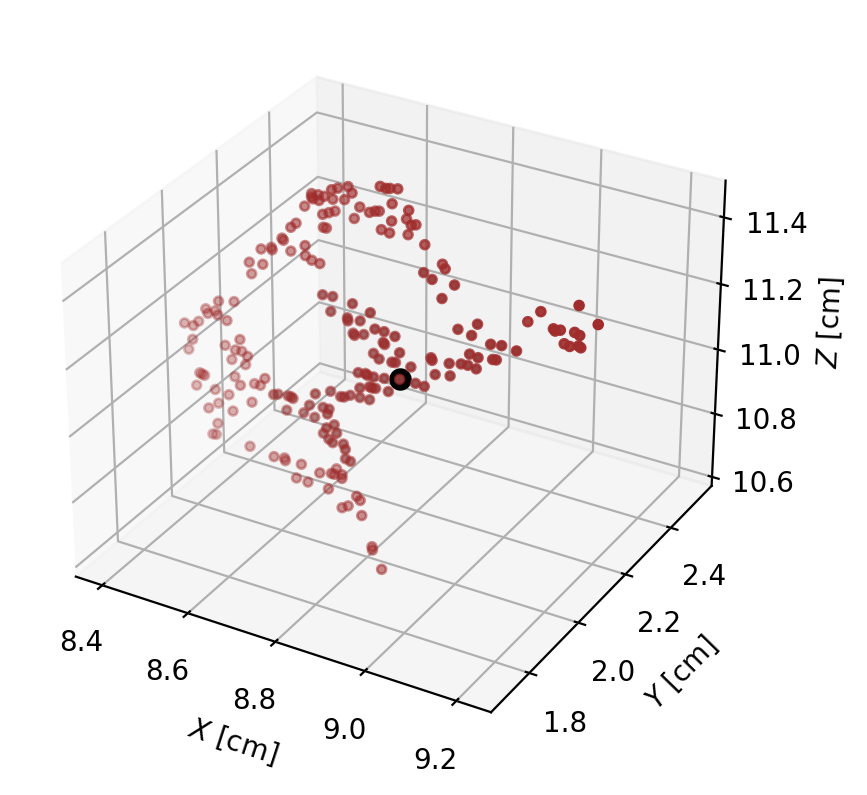

In [11]:
#%matplotlib qt
testPoint = 10
fig = sk.visualizeRegionAroundPoints(points, testPoint, neighborDistance, neighborDistance*.6, innerColor='#A02C2C', centerColor='black', s=[5, 10, 50])
ax = fig.gca()

ax.set_xlabel('$X$ [cm]')
ax.set_ylabel('$Y$ [cm]')
ax.set_zlabel('$Z$ [cm]')

#fig.tight_layout()
plt.savefig('junction_eg.svg')
plt.show()

In [5]:
def angularHistogramAroundPoint(points, index, adjMat=None, neighborDistance=25, smoothing=5, histBins=50):
    """
    Compute an angular histogram (axes are theta and phi angles) of directions to neighbors
    from the given point.
    
    Parameters
    ----------
    points : numpy.ndarray[N,3]
        All points in the point cloud (not just those
        that are neighbors). Neighbor points will be selected
        using the provided adjacency matrix.
        
    index : int
        The index of the point to compute the histogram for.
        
    adjMat : numpy.ndarray[N,N] or None
        The unweighted adjacency matrix for the points, ie.
        adjMat[i,j] == 1 iff the two i and j are neighbors, and 
        0 otherwise.
        
        If `None`, will be calculated before computing the histogram.
        Not recommended to calculating lots of histograms.
        
    neighborDistance : float
        The distance within which two points are considered to
        be neighbors. Only relevant if adjMat is not provided,
        and therefore needs to be calculated.
        
    smoothing : int (odd) or None
        Size of the gaussian smoothing kernel to use on the histogram. 
        
    histBins : int
        Number of bins to use in generating the histogram.
    Returns
    -------
    hist : numpy.ndarray[N,N]
        2D histogram data, with each axis representing a spherical angle.
        
    thetaBins : numpy.ndarray[N]
        Values of theta angle for histogram axis.
    
    phiBins : numpy.ndarray[N]
        Values of phi angle for histogram axis.

    """
    if not hasattr(adjMat, '__iter__'):
        adjMat = sk.calculateAdjacencyMatrix(points, neighborDistance)
    
    # Compute the average edge orientation for each node
    neighbors = np.where(adjMat[index] > 0)
    # Compute the direction of the displacement between each point
    displacements = points[index] - points[neighbors]

    # Compute slopes of displacement lines
    # z = y m_y + x m_x + b
    myArr = displacements[:,2] / (displacements[:,1] + 1e-8)
    mxArr = displacements[:,2] / (displacements[:,0] + 1e-8)
    interceptArr = [points[index].dot([-mxArr[j], -myArr[j], 1]) for j in range(len(displacements))]

    # Change the slopes into spherical coordinates
    magnitudes = np.sqrt(np.sum(displacements**2, axis=-1))
    theta = np.arccos(displacements[:,2]/(magnitudes + 1e-8))
    phi = np.sign(displacements[:,1]) * np.arccos(displacements[:,0] / np.sqrt(np.sum(displacements[:,:2]**2, axis=-1)))

    # Make sure there aren't any nan values
    goodIndices = np.array(np.array(np.isnan(theta), dtype=int) + np.array(np.isnan(phi), dtype=int) == 0, dtype=bool)
    thetaArr = theta[goodIndices]
    phiArr = phi[goodIndices]
    
    # Now turn into a 2D histogram
    hist, thetaBins, phiBins = np.histogram2d(thetaArr, phiArr, bins=histBins)
    
    if not smoothing is None and smoothing > 0:
        # `smoothing` is the kernel size
        singleAxis = np.arange(smoothing)
        kernelGrid = np.meshgrid(singleAxis, singleAxis)
        kernel = np.exp(-np.sum([(kernelGrid[i] - (smoothing-1)/2.)**2 for i in range(2)], axis=0) / (2*smoothing))
        
        hist = convolve(hist, kernel, mode='same') / np.sum(kernel)

    return hist, thetaBins, phiBins

def findDominantHistogramDirections(hist, thetaBins, phiBins, debug=False):
    """
    Based on the angular histogram (see angularHistogramAroundPoint()),
    compute the dominant directions, or the directions pointing towards
    neighbors.
    
    Parameters
    ----------
    hist : numpy.ndarray[N,N]
        2D histogram data, with each axis representing a spherical angle.
        
    thetaBins : numpy.ndarray[N]
        Values of theta angle for histogram axis.
    
    phiBins : numpy.ndarray[N]
        Values of phi angle for histogram axis.

    debug : bool
        Whether to plot the peak finding data (True) or not (False).
        
    Returns
    -------
    peakDirections : numpy.ndarray[P,3]
        Unit vectors in the dominant directions.
    """
    # Find peaks in the histogram
    # Peak prevalence is the range the peak spans; eg. a peak
    # that spans from the minimum to the maximum of the data has
    # a prevalence of 1
    peaks, prevalences = sk.findPeaks2D(hist, minPeakPrevalence=.5)

    # Convert from indices to angles
    peakThetaArr = thetaBins[np.array(peaks)[:,0]]
    peakPhiArr = phiBins[np.array(peaks)[:,1]]

    # Convert from (theta, phi) to (x, y, z)
    peakDirections = np.array([[np.sin(peakThetaArr[i])*np.cos(peakPhiArr[i]),
                                np.sin(peakThetaArr[i])*np.sin(peakPhiArr[i]),
                                np.cos(peakThetaArr[i])] for i in range(len(peaks))])

    if debug:
        plt.pcolor(thetaBins, phiBins, hist)
        plt.colorbar()
        for i in range(len(peaks)):
            plt.scatter(thetaBins[peaks[i][1]], phiBins[peaks[i][0]], c='red', s=50, alpha=.75)
        plt.show()
    
    return peakDirections

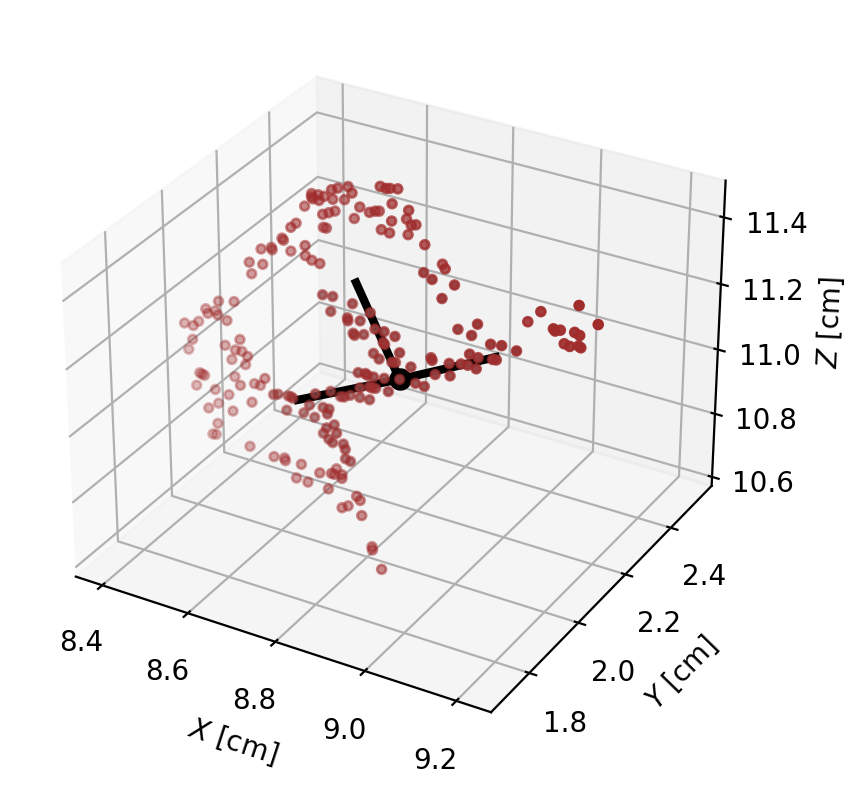

In [10]:
%matplotlib inline

testPoint = 10

hist, thetaBins, phiBins = sk.angularHistogramAroundPoint(points, testPoint, adjMat, smoothing=21)
peakDirections = sk.findDominantHistogramDirections(hist, thetaBins, phiBins, debug=False)

fig = sk.visualizeRegionAroundPoints(points, testPoint, neighborDistance, neighborDistance*.6, innerColor='#A02C2C', centerColor='black', s=[5, 10, 50])
ax = fig.gca()

for i in range(len(peakDirections)):
    linePoints = np.array([points[testPoint], points[testPoint] - .25*peakDirections[i]])
    ax.plot(linePoints[:,0], linePoints[:,1], linePoints[:,2], linewidth=3, c='black')

ax.set_xlabel('$X$ [cm]')
ax.set_ylabel('$Y$ [cm]')
ax.set_zlabel('$Z$ [cm]')

#fig.tight_layout()
plt.savefig('junction_eg_skeleton.svg')
plt.show()